In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Necessary Libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Getting the data (Pre-processed)



In [ ]:
# custom dataset class for loading the images
class CustomDataset(Dataset):
    def __init__(self, images, ela_images, labels, transform=None):
        self.images = images
        self.ela_images = ela_images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        ela_image = self.ela_images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)
            ela_image = self.transform(ela_image)

        return image, ela_image, label

In [ ]:
import pickle
#Load the loaders
with open('/content/drive/MyDrive/HKBU/CVPR/data_loaders.pkl', 'rb') as f:
    train_loader, test_loader, valid_loader = pickle.load(f)

# Model

In [ ]:
class ConcatenatedModel(nn.Module):
    def __init__(self):
        super(ConcatenatedModel, self).__init__()
        self.original_branch = models.mobilenet_v2(pretrained=True)
        self.original_branch.classifier[1] = nn.Linear(1280, 512)  # for original images
        self.ela_branch = models.resnet50(pretrained=True)
        self.ela_branch.fc = nn.Linear(2048, 512)  # for ELA processed images
        self.fc = nn.Linear(1024, 2)  # final fully connected layer for classification
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)  # dropout probability of 0.5
        self.dropout2 = nn.Dropout(p=0.5)  # additional dropout layer

    def forward(self, original_images, ela_images):
        original_features = self.original_branch(original_images)
        original_features = self.relu(original_features)  # Apply ReLU activation
        original_features = self.dropout1(original_features)  # Apply Dropout
        ela_features = self.ela_branch(ela_images)
        ela_features = self.relu(ela_features)  # Apply ReLU activation
        ela_features = self.dropout1(ela_features)  # Apply Dropout
        concatenated_features = torch.cat((original_features, ela_features), dim=1)
        concatenated_features = self.dropout2(concatenated_features)  # Apply additional Dropout
        out = self.fc(concatenated_features)
        return out


model = ConcatenatedModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ConcatenatedModel(
  (original_branch): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, 

# Loss Function and Optimizer

In [ ]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [ ]:
# the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# training the model
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, ela_images, labels in train_loader:
        images = images.to(device)
        ela_images = ela_images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images, ela_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    train_accuracy = correct / total
    train_loss = running_loss / len(train_loader)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, ela_images, labels in valid_loader:
            images = images.to(device)
            ela_images = ela_images.to(device)
            labels = labels.to(device)

            outputs = model(images, ela_images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    valid_accuracy = correct / total
    valid_loss = running_loss / len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Valid Loss: {valid_loss:.4f} - Valid Accuracy: {valid_accuracy:.4f}")

Epoch 1/15 - Train Loss: 0.6587 - Train Accuracy: 0.6057 - Valid Loss: 0.6790 - Valid Accuracy: 0.6082
Epoch 2/15 - Train Loss: 0.5038 - Train Accuracy: 0.7529 - Valid Loss: 0.6382 - Valid Accuracy: 0.6775
Epoch 3/15 - Train Loss: 0.3423 - Train Accuracy: 0.8486 - Valid Loss: 0.6787 - Valid Accuracy: 0.6951
Epoch 4/15 - Train Loss: 0.2016 - Train Accuracy: 0.9227 - Valid Loss: 1.2767 - Valid Accuracy: 0.6007
Epoch 5/15 - Train Loss: 0.1284 - Train Accuracy: 0.9503 - Valid Loss: 1.1452 - Valid Accuracy: 0.6533
Epoch 6/15 - Train Loss: 0.0886 - Train Accuracy: 0.9678 - Valid Loss: 1.6285 - Valid Accuracy: 0.6232
Epoch 7/15 - Train Loss: 0.0625 - Train Accuracy: 0.9769 - Valid Loss: 1.4986 - Valid Accuracy: 0.6558
Epoch 8/15 - Train Loss: 0.0619 - Train Accuracy: 0.9775 - Valid Loss: 1.4475 - Valid Accuracy: 0.6850
Epoch 9/15 - Train Loss: 0.0626 - Train Accuracy: 0.9762 - Valid Loss: 1.2651 - Valid Accuracy: 0.6884
Epoch 10/15 - Train Loss: 0.0499 - Train Accuracy: 0.9857 - Valid Loss: 1

# Evaluation

In [ ]:
# evaluation of the model on the test set
model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, ela_images, labels in test_loader:
        images = images.to(device)
        ela_images = ela_images.to(device)
        labels = labels.to(device)

        outputs = model(images, ela_images)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy : %0.2f" % (accuracy*100),'%')
print("Precision: %0.2f" % (precision*100),'%')
print("Recall   :", recall)
print("F1-Score :", f1)

Accuracy : 72.41 %
Precision: 67.33 %
Recall   : 0.6445497630331753
F1-Score : 0.6585956416464891


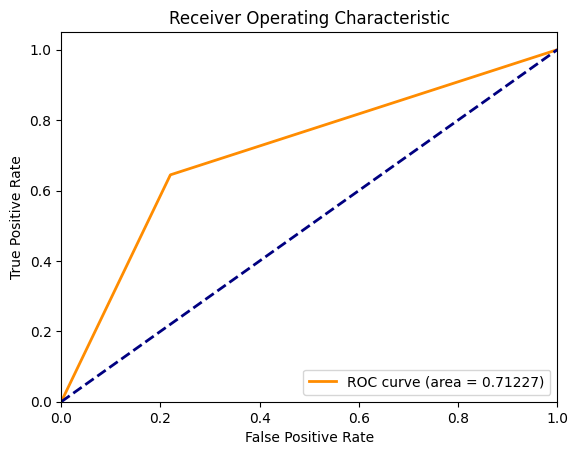

In [ ]:
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

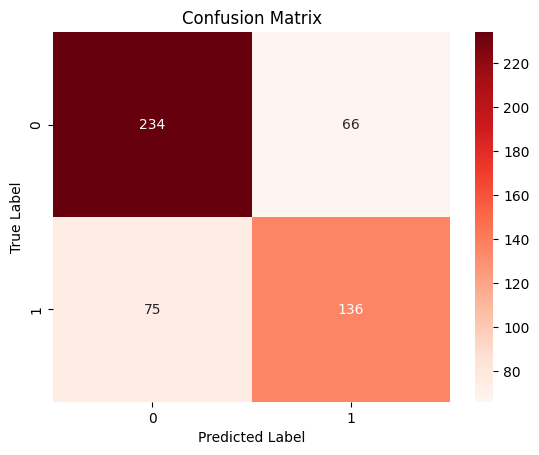

In [ ]:
confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure()
sns.heatmap(confusion, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

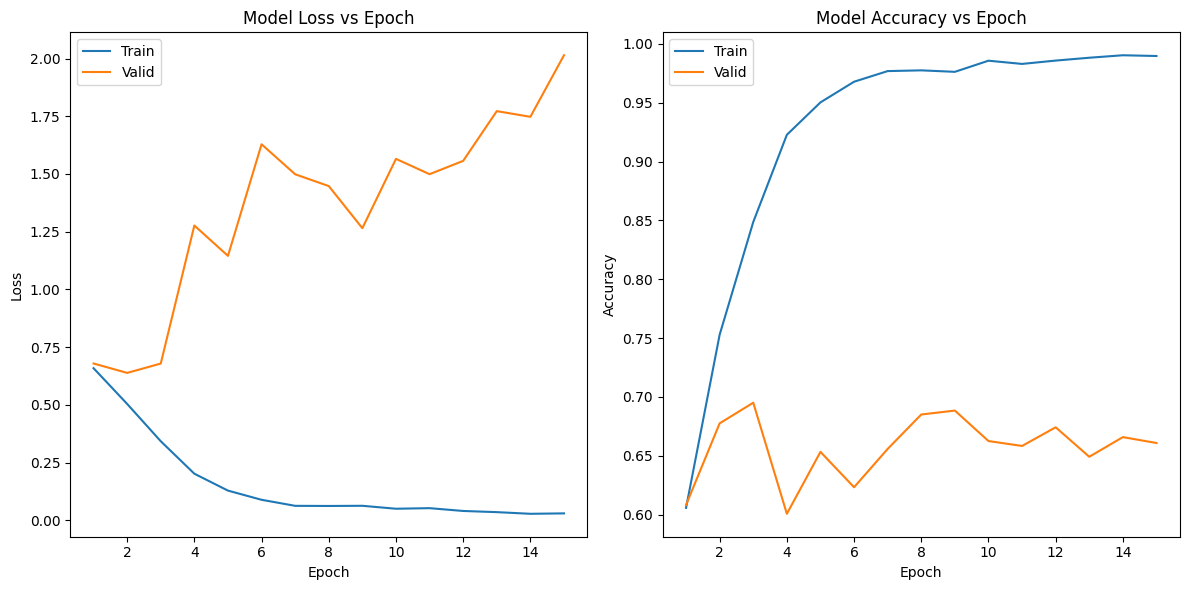

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# plot model loss vs epoch
axs[0].plot(range(1, num_epochs+1), train_losses, label='Train')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Valid')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Model Loss vs Epoch')
axs[0].legend()

# plot model accuracy vs epoch
axs[1].plot(range(1, num_epochs+1), train_accuracies, label='Train')
axs[1].plot(range(1, num_epochs+1), valid_accuracies, label='Valid')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Model Accuracy vs Epoch')
axs[1].legend()

plt.tight_layout()
plt.show()